In [1]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))
from config import *

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.model import NetSurfP2, ConvNet

from utils import *
from ssqa import *
from data import *
from pgm import *


warnings.filterwarnings("ignore")

In [2]:
torch.set_num_threads(32)

In [3]:
DATASET = "BLAT_ECOLX"
MUT_DATASET = "BLAT_ECOLX"
DATA = MUT_DATA
batch_size = 16

In [4]:
def search_pattern(path, uniprot, seq_nat):
    r"""
    Search a pattern with PDB
    Args:
        path (str): path to save data
        uniprot (str): uniprot id of the search sequence
        seq_nat (str): raw sequences for a better alignment of the pattern with the sequence
    """
    pdb_uniprot = pd.read_csv(f"{CROSS}/uniprot_pdb.csv", index_col=0)
    longest, patterns = 0, []
    best_sse = None
    for pdb in pdb_uniprot[pdb_uniprot.uni == uniprot].pdb.values:
        try:
            file_name = rcsb.fetch(pdb, "mmtf", biotite.temp_dir())
            mmtf_file = mmtf.MMTFFile()
            mmtf_file.read(file_name)
            # Transketolase homodimer
            ss_seq = np.array(list(mmtf_file["entityList"][0]["sequence"]))
            length, (m_nat, M_nat, m_mut, M_mut), _ = lcs_pattern(seq_nat, "".join(ss_seq))
            sse = mmtf_file["secStructList"]
            sse = np.array(sse[m_mut: M_mut + 1])
            length = len(sse)
            if length < longest:
                continue
            if length > longest:
                longest = length
                patterns = []
                best_sse = "".join([pdb_codes[code%8] for code in sse])
                
            sse = np.array([pdb_codes[code%8] for code in sse], dtype="U1")

            sse8 = to_onehot([dssp_codes[x] for x in sse], (None, 8))
            dss8 = (sse8[1:] - sse8[:-1])
            cls = to_onehot(np.where(dss8 == -1)[1], (None, 8)).T
            bbox = np.array([np.where(dss8 == 1)[0], np.where(dss8 == -1)[0], *cls]).T
            pat8 = np.argmax(bbox[:, 2:], 1)

            sse3 = to_onehot([abc_codes[dssp_to_abc[x]] for x in sse], (None, 3))
            dss3 = (sse3[1:] - sse3[:-1])
            cls = to_onehot(np.where(dss3 == -1)[1], (None, 3)).T
            bbox = np.array([np.where(dss3 == 1)[0], np.where(dss3 == -1)[0], *cls]).T
            pat3 = np.argmax(bbox[:, 2:], 1)
            patterns.append((list(pat3), list(pat8)))
        except:
            continue
    ratio_covered = longest / len(seq_nat)
    if ratio_covered <= 0.9:
        push(f"{path}/data.pt", "pattern", (None,None,None,None))
        return None, ratio_covered
    c_patterns3, n_patterns3, c_patterns8, n_patterns8 = [], [], [], [],
    for pat3, pat8 in patterns:
        if len(pat3) == 0:
            continue
        if pat3[0] != 2:
            pat3 = [2] + pat3
        if pat3[-1] != 2:
            pat3 = pat3 + [2]
        if pat8[0] != 7:
            pat8 = [7] + pat8
        if pat8[-1] != 7:
            pat8 = pat8 + [7]
        char_pat8 = "".join([sec_struct_codes[x] for x in pat8])
        char_pat3 = "".join(["abc"[x] for x in pat3])
        c_patterns8.append(char_pat8)
        n_patterns8.append(list(pat8))
        c_patterns3.append(char_pat3)
        n_patterns3.append(list(pat3))
    max_occ, c_pattern3, n_pattern3, c_pattern8, n_pattern8 = 0, None, None, None, None
    for c3, n3, c8, n8 in zip(c_patterns3, n_patterns3, c_patterns8, n_patterns8):
        n_occ = c_patterns8.count(c8)
        if n_occ > max_occ:
            max_occ = n_occ
            c_pattern3, n_pattern3 = c3, n3
            c_pattern8, n_pattern8 = c8, n8

    push(f"{path}/data.pt", "pattern", (c_pattern3, n_pattern3, c_pattern8, n_pattern8))

    return (c_pattern3, n_pattern3, c_pattern8, n_pattern8), ratio_covered, best_sse


In [5]:
nat_seq = "HPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
uniprot_id = "P62593"
pattern, _, best_sse = search_pattern(f"{DATA}/{MUT_DATASET}", uniprot_id, nat_seq)
c_pattern3, n_pattern3, c_pattern8, n_pattern8 = pattern

In [ ]:
infer_pattern(f"{DATA}/{DATASET}", [0])

## Pattern Matching

In [6]:
dataset = SSQAData_QA(f"{DATA}/{DATASET}/data.pt")
dataset_rbm = SSQAData_RBM(f"{DATA}/{DATASET}/data.pt")

loader = DataLoader(dataset, batch_size = 16, shuffle = False)

device = torch.device('cuda')

model_ss = NetSurfP2(50, "netsurfp2")
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp_50feats.h5"))
model_ss = model_ss.to(device)

model_ss

Available :  seq L seq_hmm pattern
Available :  seq L seq_hmm pattern


Model netsurfp2-50

In [7]:
family = "BLAT_ECOLX"
name_dataset = "Palzkill2012"
exp = "ddG_stat"

mut_df = pd.read_csv(f"{MUT_DATA}/{family}/{name_dataset}_mutation_sequences.csv", index_col=0)
isna = (mut_df["effect_prediction_epistatic"].isna()) | (mut_df["effect_prediction_independent"].isna())
isnaexp = (mut_df[exp].isna()) | isna


In [8]:
dataset = SSQAData_QA(f"{MUT_DATA}/{family}/{name_dataset}_data.pt")

seq_hmm = dataset.seq_hmm
size = seq_hmm.size(-1)

SS_HMM3 = torch.ones(3, size) / 3
SS_HMM8 = torch.ones(8, size) / 8
ss_hmm = torch.tensor(dataset[0]).float()
active_idx = torch.where((ss_hmm[:20].sum(0) > 0))[0]
pred = model_ss(ss_hmm[None, :, active_idx].cuda())
SS_HMM3[:, active_idx] = F.softmax(pred[2][0], 0).cpu()
SS_HMM8[:, active_idx] = F.softmax(pred[1][0], 0).cpu()
SS_HMM3 = SS_HMM3[None]
SS_HMM8 = SS_HMM8[None]
X = torch.cat([data[None] for data in dataset], 0)
ssqa = SSQAMut(model_ss, pattern, seq_hmm, SS_HMM3, SS_HMM8)

dp, pm = ssqa.featuring(X)
mut_df = pd.read_csv(f"{MUT_DATA}/{family}/{name_dataset}_mutation_sequences.csv", index_col=0)
isna = (mut_df["effect_prediction_epistatic"].isna()) | (mut_df["effect_prediction_independent"].isna())
isnaexp = (mut_df[exp].isna()) | isna
y = mut_df[~isnaexp][exp].values
edca = torch.tensor(mut_df["effect_prediction_epistatic"][~isnaexp]).float()
eind = torch.tensor(mut_df["effect_prediction_independent"][~isnaexp]).float()

Available :  seq L seq_hmm


(array([  1.,   0.,   0.,   1.,   2.,   2.,   0.,   0.,   2.,   2.,   0.,
          2.,   0.,   1.,   3.,   4.,   5.,   4.,   3.,   9.,   5.,   5.,
          5.,  10.,   8.,  21.,  21.,  28.,  25.,  37.,  34.,  41.,  43.,
         45.,  47.,  77.,  75.,  66.,  66.,  77.,  72.,  75.,  77.,  79.,
         67.,  65.,  69.,  73.,  58.,  63.,  75.,  60.,  56.,  71.,  73.,
         69.,  65.,  70.,  66.,  69., 108.,  57.,  82.,  94.,  90.,  95.,
         90.,  92.,  94., 122., 100., 100., 108.,  97.,  96.,  79., 122.,
         90.,  72., 106.,  98.,  79.,  70.,  57.,  84.,  73.,  60.,  47.,
         46.,  54.,  37.,  11.,  14.,  11.,   8.,   6.,   3.,   5.,   0.,
          2.]),
 array([-2.459027  , -2.37387652, -2.28872604, -2.20357556, -2.11842508,
        -2.0332746 , -1.94812412, -1.86297364, -1.77782316, -1.69267268,
        -1.6075222 , -1.52237172, -1.43722124, -1.35207076, -1.26692028,
        -1.1817698 , -1.09661932, -1.01146884, -0.92631836, -0.84116788,
        -0.7560174 , -0.67

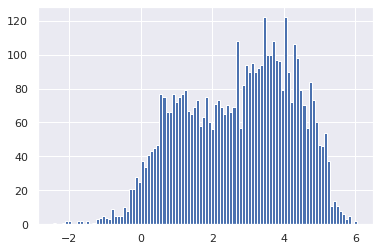

In [86]:
plt.hist(mut_df[~isnaexp][exp], bins = 100)

In [10]:
from scipy.stats import spearmanr, rankdata
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support


def best_temperature(X, y):
    e, dpunsup, pmunsup, dpsup, pmsup = X
    clf = LogisticRegression(fit_intercept=False)
    clf.fit(torch.cat([e[:, None], dpunsup[:, None], pmunsup[:, None]], 1), y)
    a, b, c = clf.coef_[0], clf.coef_[1], clf.coef_[2]
    Wunsup = 1, b / a, c / a
    clf.fit(torch.cat([e[:, None], dpsup[:, None], pmsup[:, None]], 1), y)
    a, b, c = clf.coef_[0], clf.coef_[1], clf.coef_[2]
    Wsup = 1, b / a, c / a
    return Wunsup, Wsup

def best_temperature(X, y):
    e, dpunsup, pmunsup, dpsup, pmsup = X
    clf = LogisticRegression(fit_intercept=False)
    clf.fit(torch.cat([e[:, None], dpunsup[:, None], pmunsup[:, None]], 1), y)
    a, b, c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wunsup = 1, b / a, c / a
    clf.fit(torch.cat([e[:, None], dpsup[:, None], pmsup[:, None]], 1), y)
    a, b, c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wsup = 1, b / a, c / a
    return Wunsup, Wsup


def compute_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return auc(fpr, tpr)


def cv_spearmanr(ssqa, edca, dp, pm, y, N=5):
    cv = KFold(n_splits=N, shuffle=True)
    rho_scores = {"E": 0, "sup/DP": 0, "sup/PM": 0, "sup/PM+DP": 0, "sup/E+DP": 0, "sup/E+PM": 0, "sup/E+DP+PM": 0,
                  "unsup/DP": 0, "unsup/PM": 0, "unsup/PM+DP": 0, "unsup/E+DP": 0, "unsup/E+PM": 0, "unsup/E+DP+PM": 0}
    dpunsup_, pmunsup_, dpsup_, pmsup_ = torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float()
    for i, (train_index, test_index) in enumerate(cv.split(edca)):
        ssqa.train(dp[train_index], pm[train_index], y[train_index])
        e = torch.tensor(edca[test_index])
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp[test_index], pm[test_index])
        dpunsup_[test_index], pmunsup_[test_index], dpsup_[test_index], pmsup_[test_index] = dpunsup.float(), pmunsup.float(), dpsup.float(), pmsup.float()
        y_test = y[test_index]
        (wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature(
            [e, dpunsup, pmunsup, dpsup, pmsup], y_test)
        print((wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm))
        
        rho_scores["E"] += np.abs(spearmanr(y_test, e)[0]) / N

        rho_scores["sup/DP"] += np.abs(spearmanr(y_test, dpsup)[0]) / N
        rho_scores["sup/PM"] += np.abs(spearmanr(y_test, pmsup)[0]) / N
        rho_scores["sup/PM+DP"] += np.abs(spearmanr(y_test, ws_dp * dpsup + ws_pm * pmsup)[0]) / N
        rho_scores["sup/E+DP"] += np.abs(spearmanr(y_test, ws_e * e + ws_dp * dpsup)[0]) / N
        rho_scores["sup/E+PM"] += np.abs(spearmanr(y_test, ws_e * e + ws_pm * pmsup)[0]) / N
        rho_scores["sup/E+DP+PM"] += np.abs(spearmanr(y_test, ws_e * e + ws_dp * dpsup + ws_pm * pmsup)[0]) / N

        rho_scores["unsup/DP"] += np.abs(spearmanr(y_test, dpunsup)[0]) / N
        rho_scores["unsup/PM"] += np.abs(spearmanr(y_test, pmunsup)[0]) / N
        rho_scores["unsup/PM+DP"] += np.abs(spearmanr(y_test, wu_dp * dpunsup + wu_pm * pmunsup)[0]) / N
        rho_scores["unsup/E+DP"] += np.abs(spearmanr(y_test, wu_e * e + ws_dp * dpunsup)[0]) / N
        rho_scores["unsup/E+PM"] += np.abs(spearmanr(y_test, wu_e * e + ws_pm * pmunsup)[0]) / N
        rho_scores["unsup/E+DP+PM"] += np.abs(spearmanr(y_test, wu_e * e + wu_dp * dpunsup + wu_pm * pmunsup)[0]) / N
    return rho_scores, dpunsup_, pmunsup_, dpsup_, pmsup_,

def cv_spearmanr(ssqa, edca, dp, pm, y, N=5):
    cv = KFold(n_splits=N, shuffle=True)
    rho_scores = {"E": 0, "sup/DP": 0, "sup/PM": 0, "sup/PM+DP": 0, "sup/E+DP": 0, "sup/E+PM": 0, "sup/E+DP+PM": 0,
                  "unsup/DP": 0, "unsup/PM": 0, "unsup/PM+DP": 0, "unsup/E+DP": 0, "unsup/E+PM": 0, "unsup/E+DP+PM": 0}
    dpunsup_, pmunsup_, dpsup_, pmsup_ = torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float(), torch.zeros(len(edca)).float()
    for i, (train_index, test_index) in enumerate(cv.split(edca)):
        ssqa.train(dp[train_index], pm[train_index], y[train_index])
        e = torch.tensor(edca[test_index])
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp[test_index], pm[test_index])
        dpunsup, pmunsup, dpsup, pmsup = dpunsup.float(), pmunsup.float(), torch.tensor(dpsup).float(), torch.tensor(pmsup).float()
        dpunsup_[test_index], pmunsup_[test_index], dpsup_[test_index], pmsup_[test_index] = dpunsup, pmunsup, dpsup, pmsup
        y_test = y[test_index]
        (wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature(
            [e, dpunsup, pmunsup, dpsup, pmsup], y_test)
        print((wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm))
        
        rho_scores["E"] += np.abs(compute_auc(y_test, e)) / N

        rho_scores["sup/DP"] += np.abs(compute_auc(y_test, dpsup)) / N
        rho_scores["sup/PM"] += np.abs(compute_auc(y_test, pmsup)) / N
        rho_scores["sup/PM+DP"] += np.abs(compute_auc(y_test, ws_dp * dpsup + ws_pm * pmsup)) / N
        rho_scores["sup/E+DP"] += np.abs(compute_auc(y_test, ws_e * e + ws_dp * dpsup)) / N
        rho_scores["sup/E+PM"] += np.abs(compute_auc(y_test, ws_e * e + ws_pm * pmsup)) / N
        rho_scores["sup/E+DP+PM"] += np.abs(compute_auc(y_test, ws_e * e + ws_dp * dpsup + ws_pm * pmsup)) / N

        rho_scores["unsup/DP"] += np.abs(compute_auc(y_test, dpunsup)) / N
        rho_scores["unsup/PM"] += np.abs(compute_auc(y_test, pmunsup)) / N
        rho_scores["unsup/PM+DP"] += np.abs(compute_auc(y_test, wu_dp * dpunsup + wu_pm * pmunsup)) / N
        rho_scores["unsup/E+DP"] += np.abs(compute_auc(y_test, wu_e * e + ws_dp * dpunsup)) / N
        rho_scores["unsup/E+PM"] += np.abs(compute_auc(y_test, wu_e * e + ws_pm * pmunsup)) / N
        rho_scores["unsup/E+DP+PM"] += np.abs(compute_auc(y_test, wu_e * e + wu_dp * dpunsup + wu_pm * pmunsup)) / N
    return rho_scores, dpunsup_, pmunsup_, dpsup_, pmsup_,


In [88]:
"".join(sse)

'caaaaaaaaaaaaaaccbbbbbbbbcccccbbbbbcccccbbcaaaaaaaaaaaaaaaaaccccccccbbcccccccccccaaaaacccccbbaaaaaaaaaacccaaaaaaaaaaaccaaaaaaaaaacccccccccccccaaacccccccccbbcaaaaaaaaaaaaacccccaaaaaaaaaaaacccccaaaaaaacccccbbbbbbbbcccccbbbbbbbbccccccbbbbbbbbcccccaaaaaaaaaaaaaaaaacc'

In [11]:
y = torch.tensor((mut_df[~isnaexp][exp].values < 0.5)).int()


In [12]:
#rho_scores_ind  = cv_spearmanr(ssqa, eind, dp, pm, y)
rho_scores_dca, dpunsup_, pmunsup_, dpsup_, pmsup_ = cv_spearmanr(ssqa, edca, dp, pm, y)

for k, v in rho_scores_dca.items():
    print(f"{k} : {v:.3f}")

(1, 0.6766938838875207, 0.31399621034214203) (1, 5.477306221943181, 2.640089769517963)
(1, -0.4111041837451097, -0.31208139629622994) (1, 3.8450701990242906, 2.252988429419498)
(1, -0.4136488725041994, -0.16568534517424163) (1, 5.074880191941387, 4.291240934744717)
(1, 0.1357246863976899, 0.10515119279884752) (1, 5.7779951847696145, 2.7523826322831226)
(1, 0.20402720036021288, 0.23538689998076628) (1, 4.83586200389361, 3.3072858843776083)
E : 0.772
sup/DP : 0.712
sup/PM : 0.710
sup/PM+DP : 0.729
sup/E+DP : 0.834
sup/E+PM : 0.807
sup/E+DP+PM : 0.849
unsup/DP : 0.514
unsup/PM : 0.511
unsup/PM+DP : 0.490
unsup/E+DP : 0.772
unsup/E+PM : 0.772
unsup/E+DP+PM : 0.772


In [29]:
dpsup_, pmsup_

(tensor([0.0500, 0.3500, 0.1100,  ..., 0.0200, 0.0300, 0.1800]),
 tensor([0.0000, 0.2600, 0.2600,  ..., 0.0400, 0.0300, 0.0200]))

In [122]:
ws_e, ws_dp, ws_pm = 1, 5, 3

## Single Mutations

In [149]:
x = mut_df[~isnaexp].reset_index()["name"].apply(lambda x : int(x[1:-1]) if len(x) > 2 else -1).values
y = mut_df[~isnaexp].reset_index()["name"].apply(lambda x : AA_IDS[x[-1]] if len(x) > 2 else -1).values

In [150]:
heatmap_edca = torch.zeros(len(nat_seq), 20)
heatmap_ssqa = torch.zeros(len(nat_seq), 20)
heatmap_both = torch.zeros(len(nat_seq), 20)
target = torch.zeros(len(nat_seq), 20).int()

In [120]:
torch.tensor((mut_df[~isnaexp][exp].values < 0.5)).int()

tensor([1, 1, 0,  ..., 0, 0, 0], dtype=torch.int32)

In [125]:
target[0,0]

tensor(0.)

In [151]:
for k, (i, j, e, t, dpsup, pmsup) in enumerate(zip(x, y, edca, mut_df[~isnaexp][exp].values, dpsup_, pmsup_)):
    target[i,j] = t
    heatmap_edca[i,j] = e
    heatmap_ssqa[i,j] = (ws_dp * dpsup + ws_pm * pmsup)
    heatmap_both[i,j] = (e + ws_dp * dpsup + ws_pm * pmsup)
target = target.int()

In [137]:
thr_e, acc_e = None, 0
for i in np.linspace(heatmap_edca.min(), heatmap_edca.max(), 100):
    pred = (heatmap_edca > i).int()
    acc_ = balanced_accuracy_score(target.flatten(), pred.flatten())
    if acc_ > acc_e:
        thr_e = i
        acc_e = acc_
        
thr_s, acc_s = None, 0
for i in np.linspace(heatmap_ssqa.min(), heatmap_ssqa.max(), 100):
    pred = (heatmap_ssqa > i).int()
    acc_ = balanced_accuracy_score(target.flatten(), pred.flatten())
    if acc_ > acc_s:
        thr_s = i
        acc_s = acc_

thr_b, acc_b = None, 0
for i in np.linspace(heatmap_both.min(), heatmap_both.max(), 100):
    pred = (heatmap_both > i).int()
    acc_ = balanced_accuracy_score(target.flatten(), pred.flatten())
    if acc_ > acc_b:
        thr_b = i
        acc_b = acc_
        
(thr_e, acc_e), (thr_s, acc_s), (thr_b, acc_b)

((-5.0979103319572685, 0.6853975156069216),
 (0.7464646811437126, 0.6891558912156235),
 (-4.282399996362551, 0.7355062236970922))

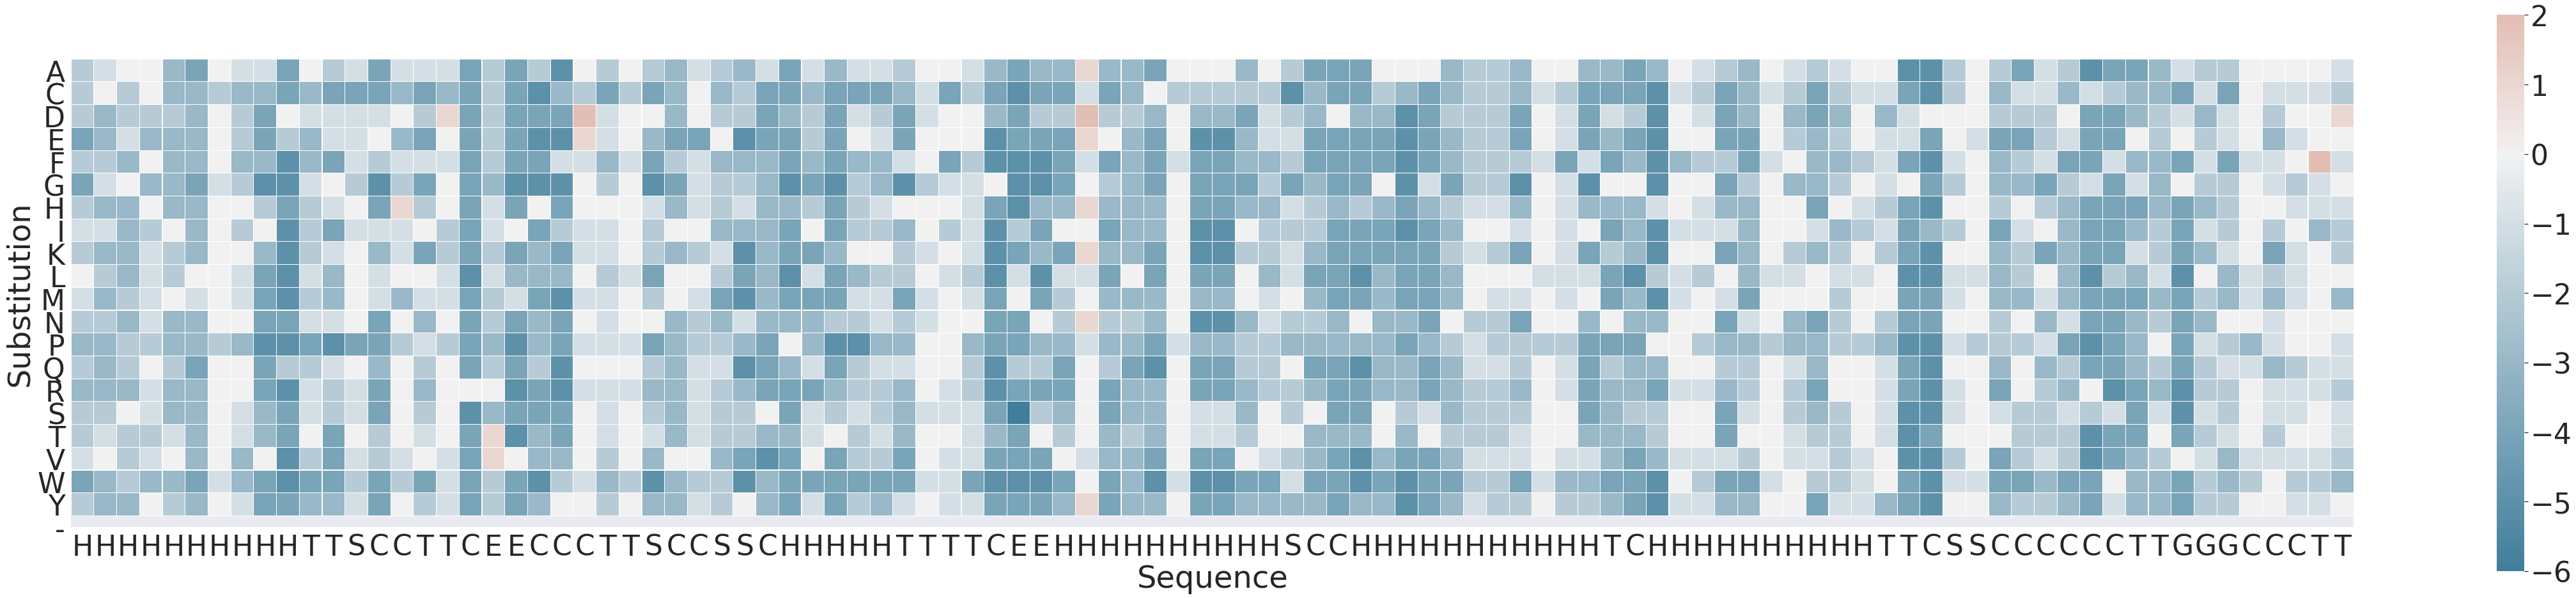

In [169]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set(font_scale=4)
plt.figure(figsize = (80, 16))
sns.heatmap(-target.t()[:,50:150].numpy(), cmap = cmap, center = 0, xticklabels = best_sse[50:150], yticklabels = AA+"-", 
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

In [19]:
import torch.nn.functional as F

In [138]:
sse3 = np.array([dssp_to_abc[x] for x in best_sse])
sse8 = np.array([x for x in best_sse])

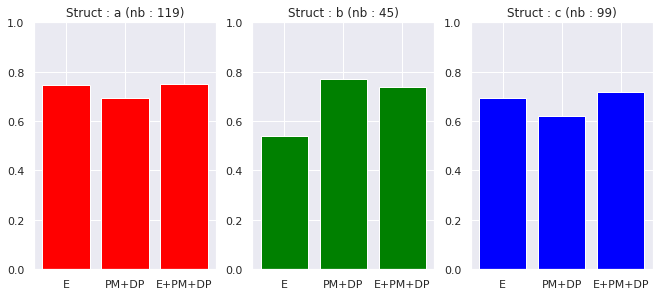

In [143]:
rho_e = []
rho_s = []
rho_b = []
colors = ["red", "green", "blue"]
for x in "abc":
    idx = np.where(sse3 == x)[0]
    if len(idx) == 0:
        rho_e.append(0)
        rho_s.append(0)
        rho_b.append(0)
        continue

    t = target[idx].flatten()
    e = heatmap_edca[idx].flatten()
    s = heatmap_ssqa[idx].flatten()
    b = heatmap_both[idx].flatten()
    rho_e.append(balanced_accuracy_score(t.int(),(e>thr_e).int()))
    rho_s.append(balanced_accuracy_score(t.int(),(s>thr_s).int()))
    rho_b.append(balanced_accuracy_score(t.int(),(b>thr_b).int()))
rho = np.array([rho_e,rho_s,rho_b])

plt.figure(figsize = (15,10))
for i, c in enumerate("abc"):
    plt.subplot(2,4,i+1)
    plt.bar(range(3), rho[:,i], color = colors[i])
    plt.xticks(range(3), ["E", "PM+DP", "E+PM+DP"])
    plt.title(f"Struct : {c} (nb : {len(np.where(sse3 == c)[0])})")
    plt.ylim(0,1)
plt.show()

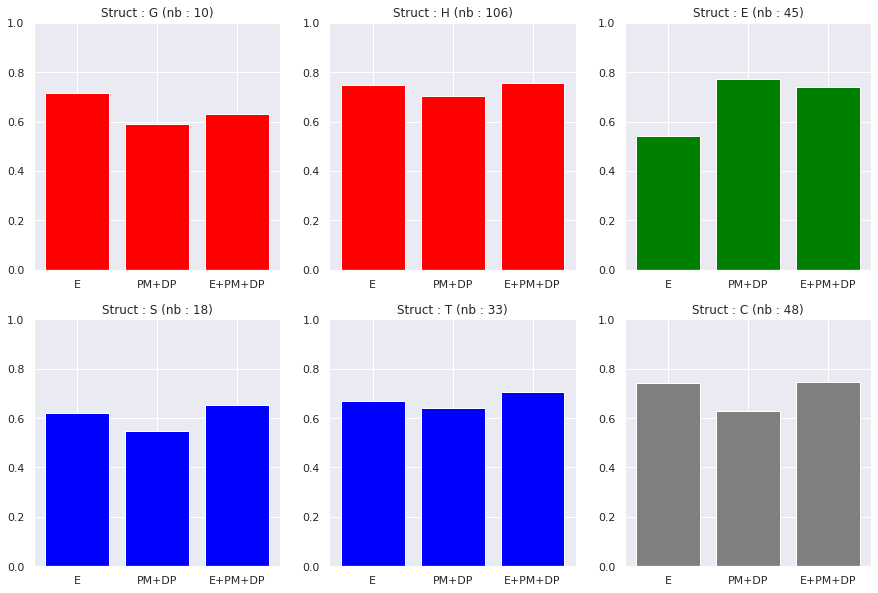

In [146]:
rho_e = []
rho_s = []
rho_b = []
colors = ["red", "red", "red", "green", "green", "blue", "blue", "gray"]
i = 0
for x in dssp_codes.keys():
    
    idx = np.where(sse8 == x)[0]
    if len(idx) == 0:
        rho_e.append(0)
        rho_s.append(0)
        rho_b.append(0)
        continue

    t = target[idx].flatten()
    e = heatmap_edca[idx].flatten()
    s = heatmap_ssqa[idx].flatten()
    b = heatmap_both[idx].flatten()
    rho_e.append(balanced_accuracy_score(t.int(),(e>thr_e).int()))
    rho_s.append(balanced_accuracy_score(t.int(),(s>thr_s).int()))
    rho_b.append(balanced_accuracy_score(t.int(),(b>thr_b).int()))
rho = np.array([rho_e,rho_s,rho_b])

plt.figure(figsize = (15,10))
j = 1
for i, c in enumerate(dssp_codes.keys()):
    if i == 3 or i ==2:
        continue
    plt.subplot(2,3,j)
    plt.bar(range(3), rho[:,i], color = colors[i])
    plt.xticks(range(3), ["E", "PM+DP", "E+PM+DP"])
    plt.title(f"Struct : {c} (nb : {len(np.where(sse8 == c)[0])})")
    plt.ylim(0,1)
    j+=1
plt.show()

In [67]:
thr_e, thr_s, thr_b

(-5.0979103319572685, 0.40555556058281594, -4.6921193238460654)

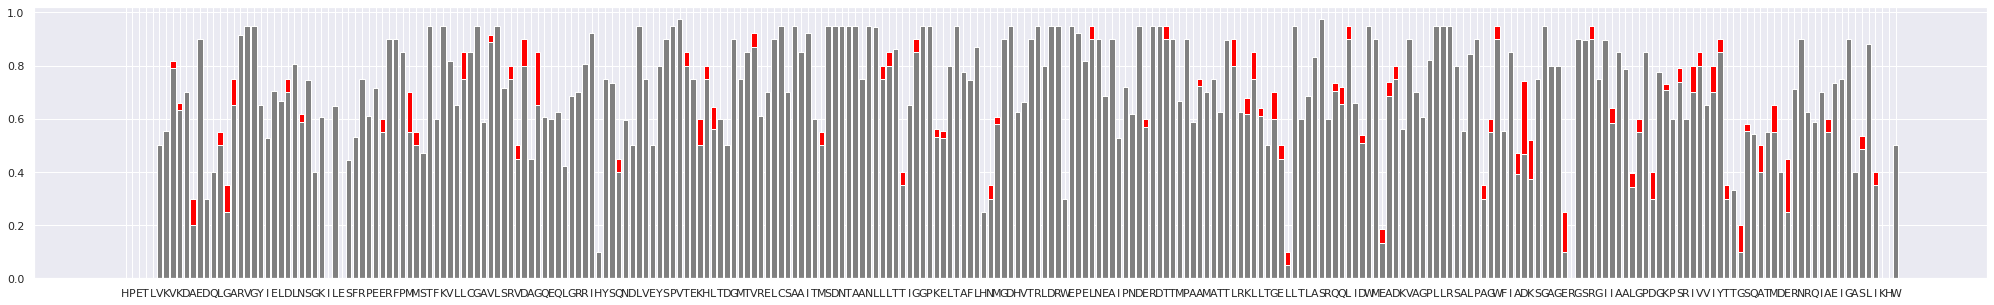

In [70]:
from scipy.stats import spearmanr,pearsonr
from sklearn.metrics import *

rho_e = []
rho_s = []
rho_b = []

for t,e,s,b in zip(target, heatmap_edca, heatmap_ssqa, heatmap_both):
    rho_e.append(balanced_accuracy_score(t.int(),(e>thr_e).int()))
    rho_s.append(balanced_accuracy_score(t.int(),(s>thr_s).int()))
    rho_b.append(balanced_accuracy_score(t.int(),(b>thr_b).int()))
    
plt.figure(figsize=(35,5))

plt.bar(range(len(rho_b)), [max(0,x) for x in rho_b], color = "red")
plt.xticks(range(len(rho_b)), nat_seq)
plt.bar(range(len(rho_e)), [max(0,x) for x in rho_e], color = "gray")
plt.xticks(range(len(rho_e)), nat_seq)

plt.show()

In [20]:
rho_e, rho_s, rho_b = torch.tensor(rho_e), torch.tensor(rho_s), torch.tensor(rho_b)

batch_size = 100
N = len(rho_e)
best_sse2 = [dssp_to_abc[x] for x in best_sse]
best_sse2 = best_sse2 + ["-"]*100
plt.figure(figsize=(15,7))

for batch_idx in range(N//batch_size + 1):
    plt.subplot(3,1,batch_idx+1)
    pad = (0,0)
    if batch_size * (batch_idx+1) > N:
        pad =  (0, -N%batch_size)
    plt.bar(range(batch_size), F.pad(rho_b[batch_size * batch_idx: batch_size * (batch_idx+1)], pad), color = "red")
    plt.bar(range(batch_size), F.pad(rho_e[batch_size * batch_idx: batch_size * (batch_idx+1)], pad), color = "gray")
    plt.ylim(0,1)
    plt.xticks(range(batch_size), best_sse2[batch_size * batch_idx: batch_size * (batch_idx+1)])
    plt.legend(["E_DCA + SSQA", "E_DCA"])
    if batch_idx ==1:
        plt.ylabel("Spearman Rho with experimental data")
    else:
        plt.ylabel("  ")
plt.show()


NameError: name 'rho_e' is not defined

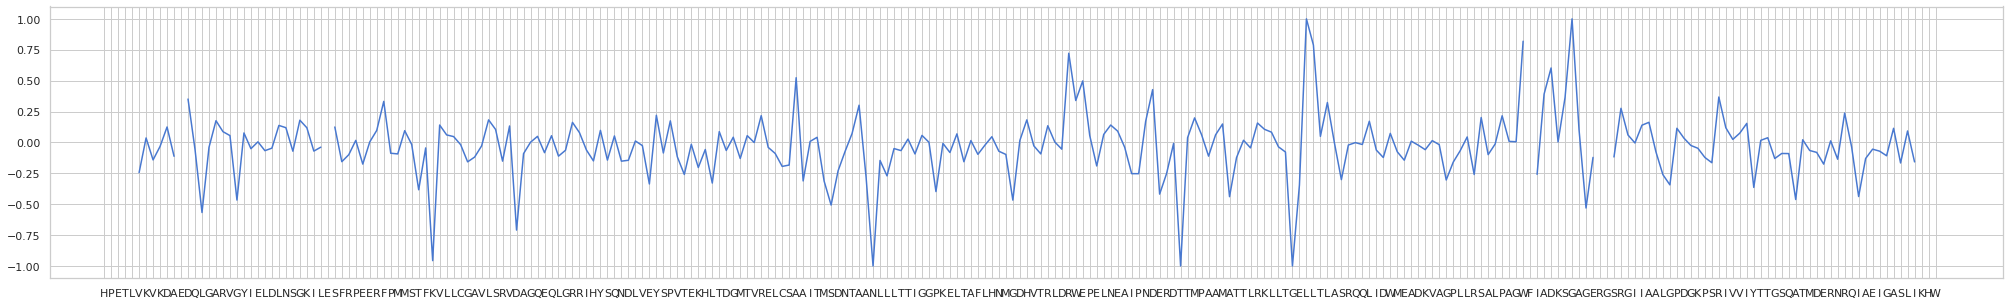

In [167]:
plt.figure(figsize=(35,5))

plt.plot(torch.tensor([np.log(b/e) for b, e in zip(rho_b, rho_e)]).clamp(-1,1))
plt.xticks(range(len(rho_s)), nat_seq)
plt.show()

In [209]:
colors = {"a":"red", "b":"green", "c":"blue"}

In [220]:
a_idx = np.where(np.array(best_sse2) == "a")[0]
b_idx = np.where(np.array(best_sse2) == "b")[0]
c_idx = np.where(np.array(best_sse2) == "c")[0]

In [225]:
rho_b[torch.where(rho_b != rho_b)[0]] = 0
rho_e[torch.where(rho_e != rho_e)[0]] = 0
rho_s[torch.where(rho_s != rho_s)[0]] = 0

In [226]:
(rho_b - rho_e)[a_idx].mean(), (rho_b - rho_e)[b_idx].mean(), (rho_b - rho_e)[c_idx].mean()

(tensor(-0.0205, dtype=torch.float64),
 tensor(-0.0128, dtype=torch.float64),
 tensor(-0.0126, dtype=torch.float64))

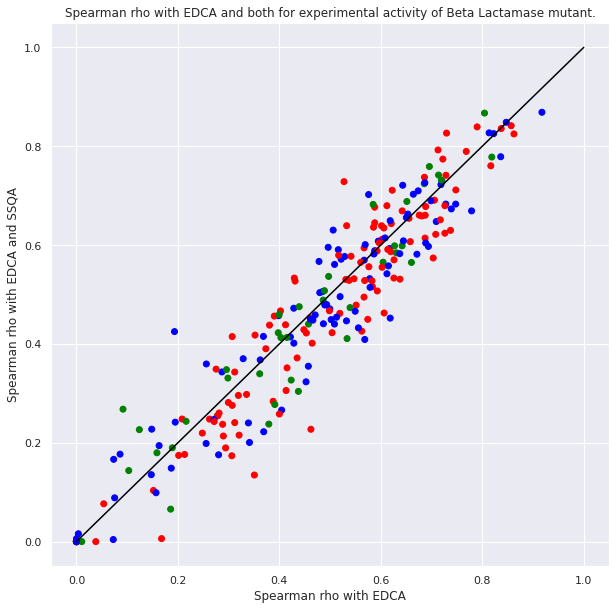

In [216]:
plt.figure(figsize=(10,10))
plt.scatter([max(0,x) for x in rho_e], [max(0,x) for x in rho_b], c = [colors[x] for x in best_sse2[:263]])
plt.xlabel("Spearman rho with EDCA")
plt.ylabel("Spearman rho with EDCA and SSQA")
plt.plot([0,1],[0,1], c = "black")
plt.title("Spearman rho with EDCA and both for experimental activity of Beta Lactamase mutant.")
plt.show()

In [156]:
data_scatter = pd.DataFrame()
data_scatter["rho_ssqa"] = heatmap_ssqa.flatten()
data_scatter["rho_edca"] = heatmap_edca.flatten()
data_scatter["rho_both"] = heatmap_both.flatten()

data_scatter["exp"] = -target.flatten()

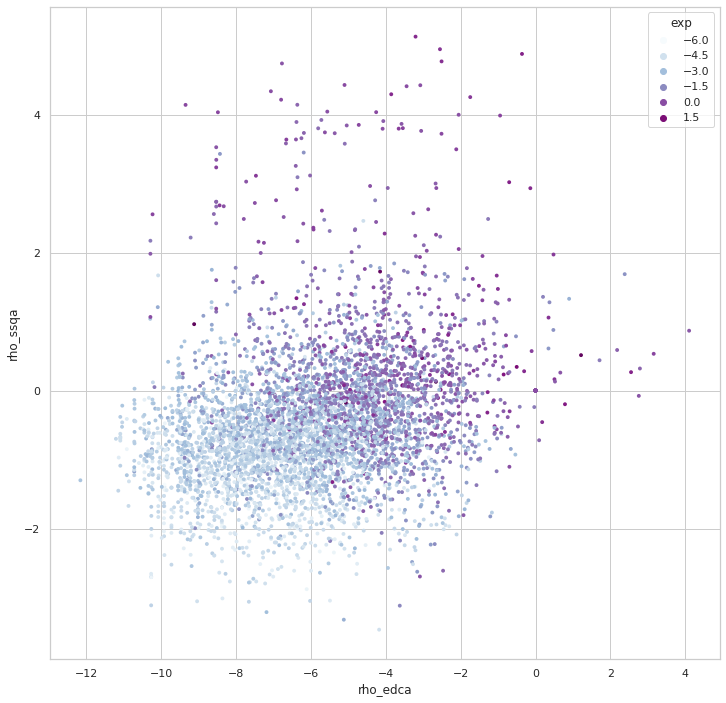

In [157]:
plt.figure(figsize= (12, 12))
sns.set(style="whitegrid", palette="muted")

sns.scatterplot(data = data_scatter, x="rho_edca", y="rho_ssqa",hue="exp", s=15,
                sizes=(1, 8), linewidth=0, palette = "BuPu")

plt.show()

In [129]:
stepx, stepy = 50, 30
mx, Mx, my, My = min(data_scatter.rho_edca), max(data_scatter.rho_edca), min(data_scatter.rho_ssqa), max(data_scatter.rho_ssqa)
px = (Mx-mx)/stepx
py = (My-my)/stepy
density_map = -6 * np.ones((stepx, stepy))
for i in range(N_step):
    for j in range(N_step):
        ds = data_scatter[(data_scatter.rho_edca >= mx + i*px) & (data_scatter.rho_edca < mx + i*px + px) & (data_scatter.rho_ssqa >= my + j*py) & (data_scatter.rho_ssqa < my + i*py + py)]["exp"]
        if len(ds)>0:
            density_map[i,j] = ds.mean() 
density_map = density_map.T

<AxesSubplot:>

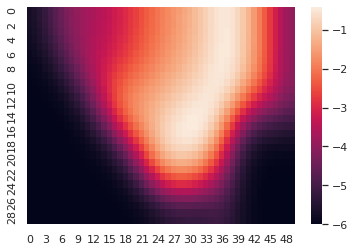

In [130]:
from scipy.ndimage import gaussian_filter
sns.heatmap(gaussian_filter(density_map,3))

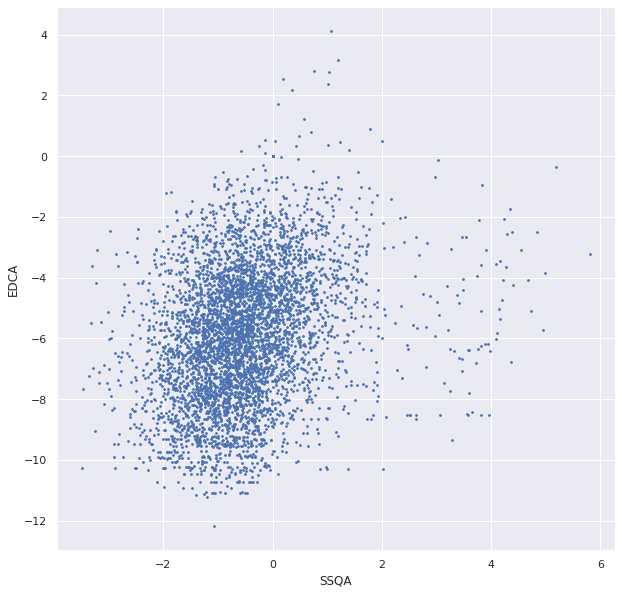

In [86]:
plt.figure(figsize=(10,10))
plt.scatter(heatmap_ssqa, heatmap_edca, s=3)
plt.xlabel("SSQA")
plt.ylabel("EDCA")
plt.show()

## RBM with rejection

In [248]:
import os
all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]
all_files.sort()

all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]

all_files = ['rbm_local_rejection_sampling_T_0.5',
             'rbm_local_rejection_sampling_T_0.6',
             'rbm_local_rejection_sampling_T_0.65',
            'rbm_local_rejection_sampling_T_0.7',]

In [249]:
all_ssqa_sup, all_ssqa_unsup, all_edca, all_both = [],[],[],[]
for filename in all_files:
    ssqa_sup, ssqa_unsup, edca_, both = [],[],[],[]
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    
    for i in tqdm(range(len(x)//batch_size + 1)):
        x_ = x[i*batch_size:(i+1)*batch_size]
        e = model1.integrate_likelihood({"sequence":x_}, "hidden").detach()/data_rbm.size(-1) - model1.Z
        edca_.append(e)
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(x_[:,1:])
        ssqa_unsup.append(torch.tensor(pmunsup.detach()))
        ssqa_sup.append(torch.tensor((dpsup + pmsup)))
        both.append(torch.tensor((1.3 * e.numpy()+dpsup + pmsup)))
    all_ssqa_sup.append(torch.cat(ssqa_sup,0))
    all_ssqa_unsup.append(torch.cat(ssqa_unsup,0))
    all_edca.append(torch.cat(edca_,0))
    all_both.append(torch.cat(both,0))
all_ssqa_sup = torch.cat([t.view(1, *t.size()) for t in all_ssqa_sup],0)
all_ssqa_unsup = torch.cat([t.view(1, *t.size()) for t in all_ssqa_unsup],0)
all_edca = torch.cat([t.view(1, *t.size()) for t in all_edca],0)
all_both = torch.cat([t.view(1, *t.size()) for t in all_both],0)

100%|██████████| 1/1 [00:34<00:00, 34.61s/it]


In [288]:
(all_both).float().mean(1)

tensor([-0.2786, -0.2223, -0.0402, -0.5049])

In [284]:
df = pd.DataFrame(columns = ["val", "Rejection"], index = range(1500))
df["val"] = (all_both.view(-1))[:1500]
df["Rejection"][:499] = "T = 0 (no rejection)"
df["Rejection"][500:999] = "T = 0.6 (low rejection)"
df["Rejection"][1000:1499] = "T = 0.65 (high rejection)"
#df["cat"][1500:] = "T = 0.7"

In [273]:
["T = 0 (no rejection)", "T = 0.6 (low rejection)", "T = 0.65 (high rejection)"]

['T = 0 (no rejection)',
 'T = 0.6 (low rejection)',
 'T = 0.65 (high rejection)']

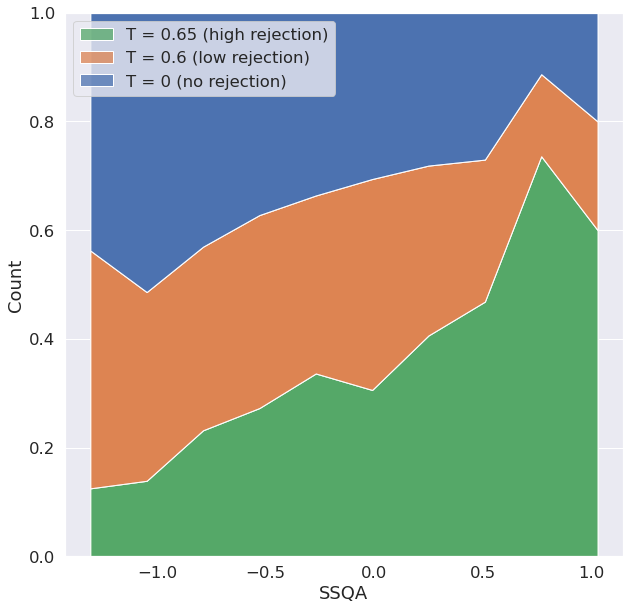

In [287]:
sns.set(style="white")
colors = "rgb"
sns.set(font_scale = 1.5)

plt.figure(figsize=(10,10))
for i,m in enumerate((all_ssqa_sup/2)):
    sns.histplot(df, x="val", stat="count", hue = "Rejection", bins = 10, multiple = "fill", element="poly", legend = False)
    #plt.ylim(0, 0.8)
plt.xlabel("SSQA")
plt.legend(["T = 0 (no rejection)", "T = 0.6 (low rejection)", "T = 0.65 (high rejection)"][::-1], loc='upper left')
#plt.xlim(0,0.8)
plt.show()

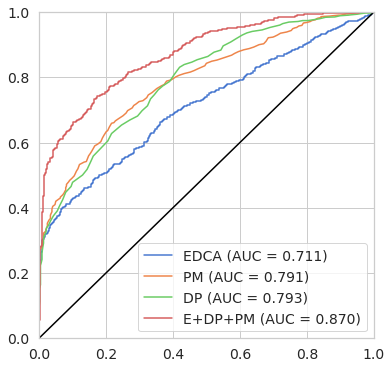

In [34]:
cond = (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df.edca > -25)
y = torch.tensor(df["is_active"][cond].values)
pred_dot = df["pred_dot"][cond]
pred_matching = df["pred_matching"][cond]
pred_dot_unsupervised = df["pred_dot_unsupervised"][cond]
pred_matching_unsupervised = df["pred_matching_unsupervised"][cond]
edca = torch.exp(torch.tensor(df["edca"][cond].values))

m1 = torch.tensor(pred_dot_unsupervised.values)
m2 = torch.tensor(pred_matching_unsupervised.values)
m3 = torch.tensor(pred_dot.values)
m4 = torch.tensor(pred_matching.values)
         
(wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature([edca, m1, m2, m3, m4], y)

legs = []
plt.figure(figsize=(6,6))

fpr, tpr, _ = roc_curve(1-y, -edca)
plt.plot(fpr, tpr)
legs.append(f"EDCA (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -m4)
plt.plot(fpr, tpr)
legs.append(f"PM (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -m3)
plt.plot(fpr, tpr)
legs.append(f"DP (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -(ws_e * edca  + ws_dp * m3 + ws_pm * m4))
plt.plot(fpr, tpr)
legs.append(f"E+DP+PM (AUC = {auc(fpr, tpr):.3f})")

plt.legend(legs,fontsize=14)
#plt.title("Supervised SSQA on low energy samples (EDCA < 25)", fontsize=16)
plt.plot([0,1], [0,1], c="black")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

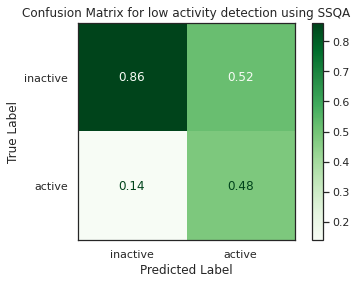

In [154]:
THRES = 0.45
y = df[(df.origin == "DCA") & (-df.edca < 25)]["ssqa"]
gt = df[(df.origin == "DCA")& (-df.edca < 25)]["is_active"]
cm = confusion_matrix(gt, np.array(y > THRES, dtype = int), normalize = "pred")
sns.set(style="white", palette="muted")
cmd = ConfusionMatrixDisplay(cm, display_labels=["inactive","active"])
ax = cmd.plot(cmap='Greens')
plt.title("Confusion Matrix for low activity detection using SSQA")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
T1 = np.linspace(1, 3, 25)
T2 = np.linspace(0.3, 0.6, 25)
best_acc, t = 0,None
for t1 in T1:
    for t2 in T2:
        sub = df[(df.origin == "DCA") & (-df.edca < t1) & (df["ssqa"] > t2)].is_active
        acc = sub.mean()
        N = len(sub)
        if acc > best_acc:
            best_acc = acc
            t = (t1, t2, N, acc)
best_acc

0.7980769230769231

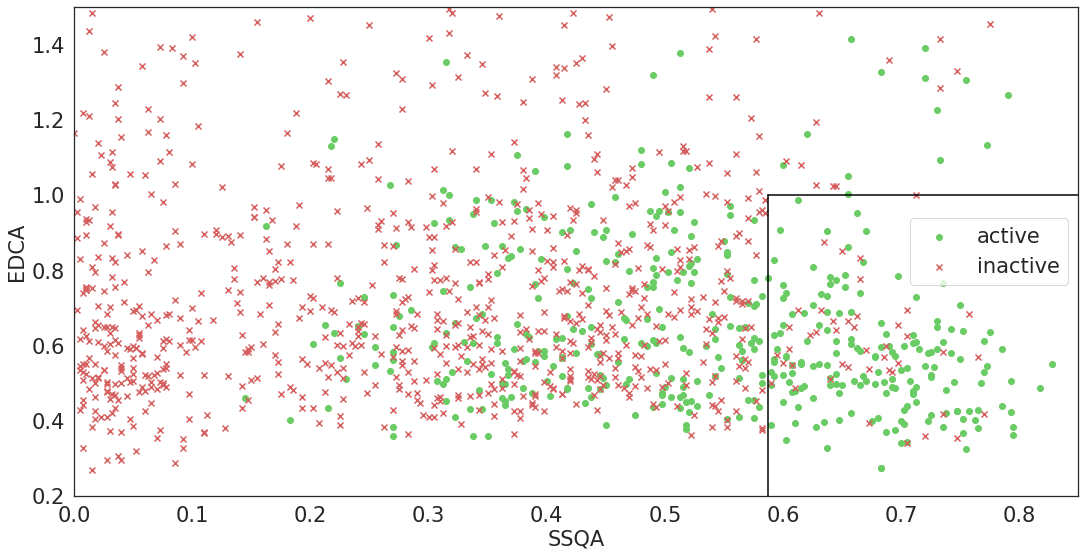

In [54]:
plt.figure(figsize=(18,9))
plt.scatter(df["ssqa"][(df.origin == "DCA") & (df.is_active == 1)],
            -df["edca"][(df.origin == "DCA") & (df.is_active == 1)],
            c="g", marker="o")
plt.scatter(df["ssqa"][(df.origin == "DCA") & (df.is_active == 0)], 
            -df["edca"][(df.origin == "DCA") & (df.is_active == 0)], 
             c="r", marker="x")
plt.legend(["active", "inactive"], fontsize=21)
plt.plot((t[1],t[1]), [-50,t[0]], c = "black")
plt.plot([t[1],100], (t[0],t[0]), c = "black")
plt.xlabel("SSQA", fontsize=21)
plt.ylabel("EDCA", fontsize=21)
plt.ylim(0.2,1.5)
plt.xlim(0,0.85)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
#plt.title("SSQA and EDCA of generated samples (85% active in the black box)", fontsize=21)
plt.show()

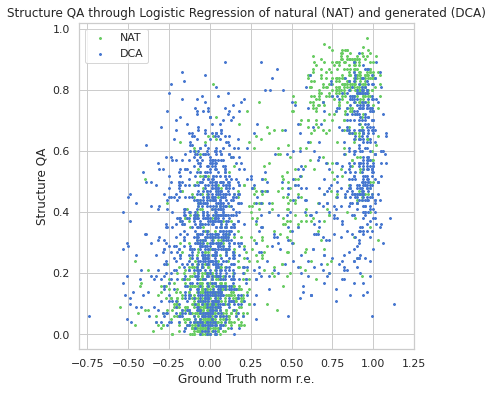

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(df["norm r.e."][(df.origin == "DCA") & df.is_active], 
            comb[df.origin == "NAT"], c="g", marker="o", s=4)
plt.scatter(df["norm r.e."][(df.origin == "DCA") & (~df.is_active)], 
            comb[df.origin == "DCA"], c="r", marker="x", s=4)
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("Structure QA")
plt.xlim(-0.8, 1.25)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA)")

plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df[(df.origin == "NAT")]["norm r.e."].values, 
            df[(df.origin == "NAT")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="g", marker="x")
plt.scatter(df[(df.origin == "DCA")]["norm r.e."].values, 
            df[(df.origin == "DCA")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="b", marker="x")
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("E_DCA")
# plt.xlim(-0.8, 1.25)
# plt.ylim(-0.01, 0.85)
plt.title("E_DCA of natural (NAT) and generated (DCA)")

plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["struct QA"], 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["EDCA (rel. to EcCM)"].values, c="g", marker="o", s=5)
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["struct QA"], 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["EDCA (rel. to EcCM)"].values, c="r", marker="x", s=5)
plt.legend(["active", "inactive"], loc = 1)
plt.xlabel("Structure QA")
plt.ylabel("E_DCA")
plt.ylim(-25, 75)
plt.title("Structure E_DCA function of Structure QA")

plt.show()

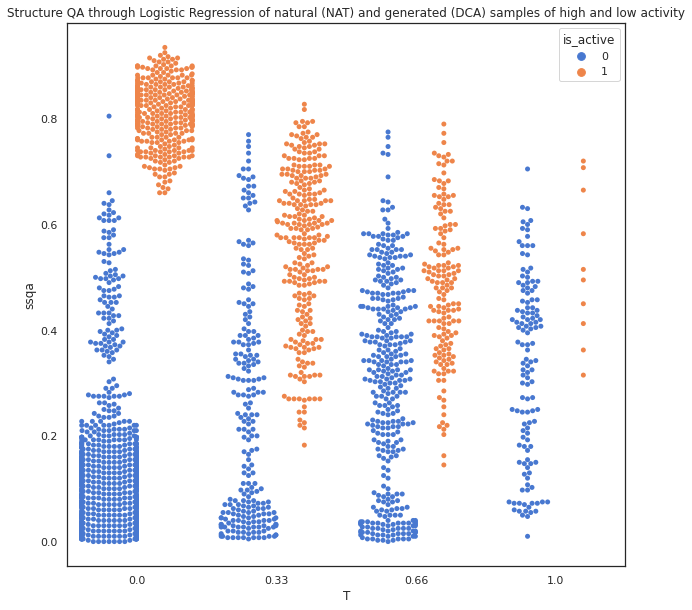

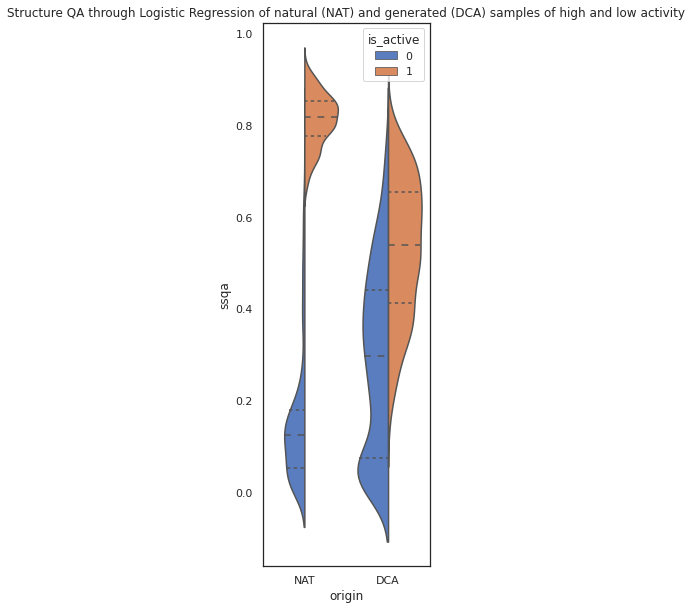

In [57]:
plt.figure(figsize=(10,10))
sns.swarmplot(x = "T", 
               y = "ssqa", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               palette = "muted",
               split = True,)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
#plt.ylim(-0.01, 1)
plt.show()

plt.figure(figsize=(3,10))
sns.violinplot(x = "origin", 
               y = "ssqa", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               inner = "quartile", 
               palette = "muted",
               split = True,)

plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
#plt.ylim(-0.2, 1)
plt.show()